In [13]:
# Modules will be reloaded every time a cell is executed
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn import utils
from sklearn.ensemble import HistGradientBoostingRegressor, GradientBoostingRegressor

from funmirtar.models.constants import SEEDS_TO_COUNT, SEED_COUNT_COLUMNS
from funmirtar.utils.plots import plot_correlation, plot_multiple_cdfs_with_medians


In [15]:
FOLDER_PATH = "../data/preprocessed_for_ml/"
TRAIN_OUTPUT_FEATURES_PATH = Path(
    FOLDER_PATH + '3utr.sequences.refseq_id.mirna_fc.seed_cls.sequence.signal.conservation.seed_cls.ts_preds.train.pkl'
)
TEST_OUTPUT_FEATURES_PATH = Path(
    FOLDER_PATH + '3utr.sequences.refseq_id.mirna_fc.seed_cls.sequence.signal.conservation.seed_cls.ts_preds.test.pkl'
)

TRAIN_OUTPUT_FEATURES_PATH, TEST_OUTPUT_FEATURES_PATH

(PosixPath('../data/preprocessed_for_ml/3utr.sequences.refseq_id.mirna_fc.seed_cls.sequence.signal.conservation.seed_cls.ts_preds.train.pkl'),
 PosixPath('../data/preprocessed_for_ml/3utr.sequences.refseq_id.mirna_fc.seed_cls.sequence.signal.conservation.seed_cls.ts_preds.test.pkl'))

In [16]:
utils.check_random_state(3)
np.random.seed(1)

In [17]:
COLUMNS_FOR_PRED = [
    'transcript_length',
    'signal_binding_sites_count', 'signal_max', 'mean', 'std',
    'median', 'iqr', 'peak_count', 'mean_crossings'
]
COLUMNS_FOR_PRED.extend(SEEDS_TO_COUNT)
COLUMNS_FOR_PRED.extend(SEED_COUNT_COLUMNS)

In [18]:
data_train = pd.read_pickle(TRAIN_OUTPUT_FEATURES_PATH)
data_test = pd.read_pickle(TEST_OUTPUT_FEATURES_PATH)

In [19]:
x_seeds_train = data_train[SEED_COUNT_COLUMNS]
y_train = data_train.label

x_seeds_test = data_test[SEED_COUNT_COLUMNS]
y_test = data_test.label

In [22]:
data_train.columns

Index(['refseq_mrna', 'miRNA', 'signal', 'conservation_phylo', 'gene_symbol',
       'ensembl_gene_id', 'utr3_start', 'utr3_end', 'ensembl_gene_id_version',
       'external_gene_name', 'ensembl_transcript_id',
       'ensembl_transcript_id_version', 'transcript_start', 'transcript_end',
       'transcript_length', 'strand', 'chromosome', 'miRNA_seq', 'sequence',
       'fold_change', 'label', 'kmer8_count_1', 'kmer8_count_2',
       'kmer8_count_3', 'kmer8_count_4', 'kmer8_count_5', 'kmer8_count_6',
       'kmer7_count_1', 'kmer7_count_2', 'kmer7_count_3', 'kmer7_count_4',
       'kmer7_count_5', 'kmer7_count_6', 'kmer6_count_1', 'kmer6_count_2',
       'kmer6_count_3', 'kmer6_count_4', 'kmer6_count_5', 'kmer6_count_6',
       'kmer6_bulge_count_1', 'kmer6_bulge_count_2', 'kmer6_bulge_count_3',
       'kmer6_bulge_count_4', 'kmer6_bulge_count_5', 'kmer6_bulge_count_6',
       'kmer6_bulge_or_mismatch_count_1', 'kmer6_bulge_or_mismatch_count_2',
       'kmer6_bulge_or_mismatch_count_3'

In [20]:
x_seeds_signal_train = data_train[COLUMNS_FOR_PRED].fillna(0,inplace=False)
x_seeds_signal_test = data_test[COLUMNS_FOR_PRED].fillna(0,inplace=False)

KeyError: "['kmer6_bulge_or_mismatch_count'] not in index"

In [ ]:
y_targetscan_weighted_test = data_test['label']
y_pred_targetscan_weighted_test = data_test['weighted context++ score percentile'].fillna(0,inplace=False)

In [ ]:
y_targetscan_weighted_train = data_train['label']
y_pred_targetscan_weighted_train = data_train['weighted context++ score percentile'].fillna(0,inplace=False)

### Train seed and signal based models

In [ ]:
y_train_fc = data_train.fold_change
y_test_fc = data_test.fold_change

# model_lr = LogisticRegression(max_iter=1000)
# model_lr.fit(x_seeds_signal_train, y_train_fc)

model_tree_signal_fc = GradientBoostingRegressor()
model_tree_signal_fc.fit(x_seeds_signal_train, y_train_fc)

y_pred_seeds_signal_tree_train_fc = model_tree_signal_fc.predict(x_seeds_signal_train)
y_pred_seeds_signal_tree_test_fc = model_tree_signal_fc.predict(x_seeds_signal_test)

<Figure size 1500x1500 with 0 Axes>

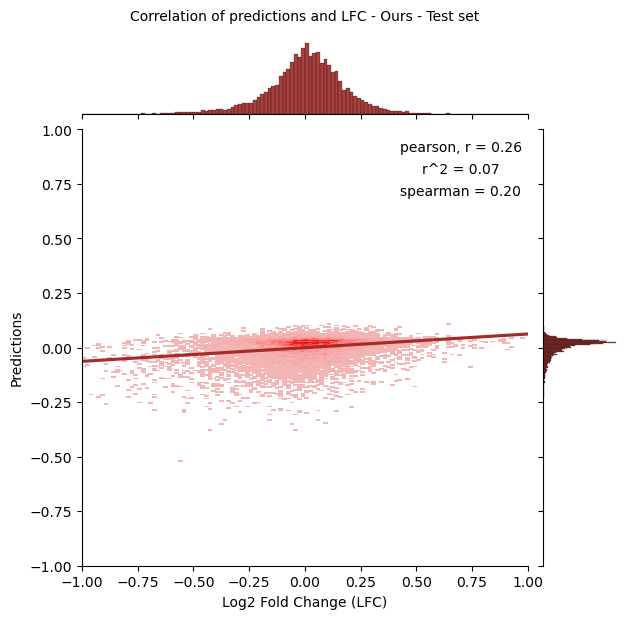

In [ ]:
plot_correlation(
    y_test_fc,
    y_pred_seeds_signal_tree_test_fc,
    title_sufix='Ours - Test set'
)

<Figure size 1500x1500 with 0 Axes>

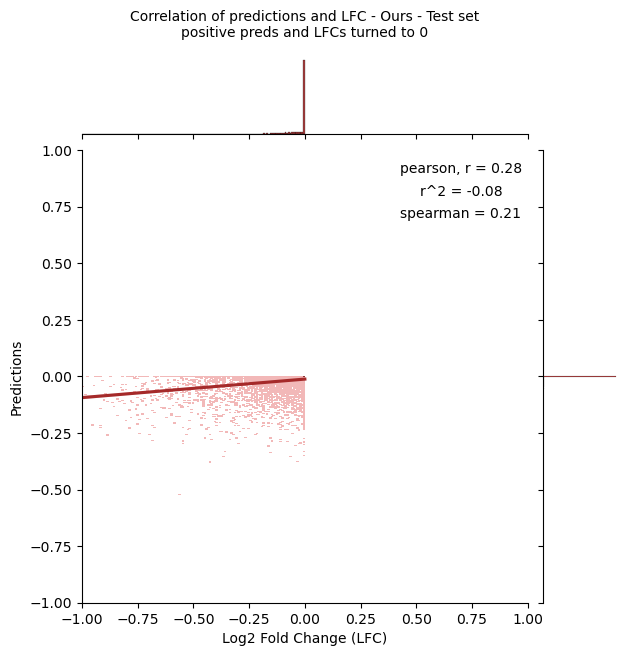

In [ ]:
y_pred_seeds_signal_tree_test_fc_positive_preds_zeroed = [
    x if x<0 else 0 for x in y_pred_seeds_signal_tree_test_fc
]
test_fc_positive_preds_zeroed = [x if x<0 else 0 for x in y_test_fc]

plot_correlation(
    test_fc_positive_preds_zeroed, 
    y_pred_seeds_signal_tree_test_fc_positive_preds_zeroed,
    'Ours - Test set\npositive preds and LFCs turned to 0'
)

<Figure size 1500x1500 with 0 Axes>

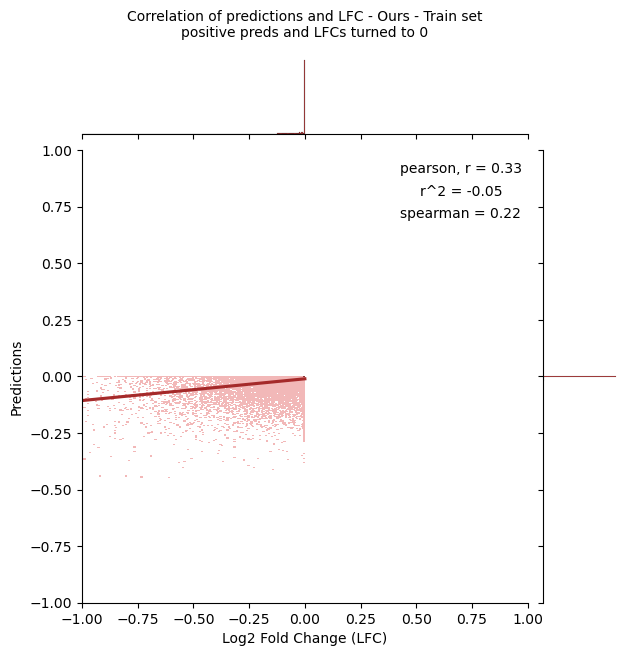

In [ ]:
train_fc_positive_preds_zeroed = [x if x<0 else 0 for x in y_train_fc]
y_pred_seeds_signal_tree_train_fc_positive_preds_zeroed = [
    x if x<0 else 0 for x in y_pred_seeds_signal_tree_train_fc
]

plot_correlation(
    train_fc_positive_preds_zeroed, 
    y_pred_seeds_signal_tree_train_fc_positive_preds_zeroed,
    'Ours - Train set\npositive preds and LFCs turned to 0'
)

<Figure size 1500x1500 with 0 Axes>

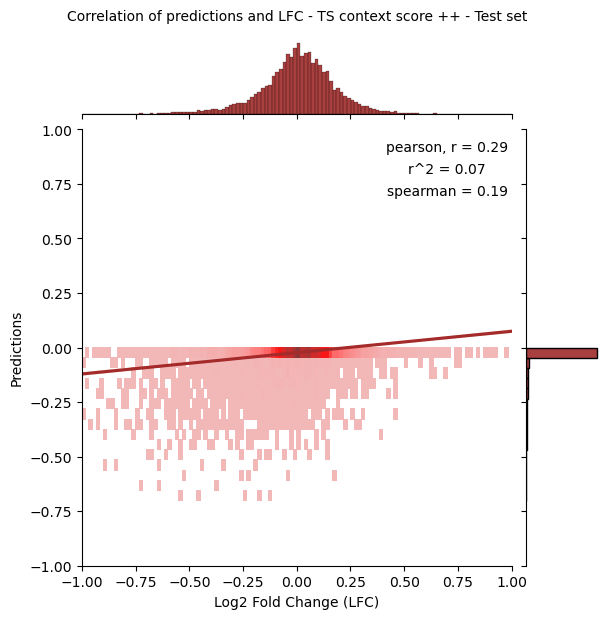

In [ ]:
plot_correlation(
    y_test_fc,
    data_test['weighted context++ score'],
    'TS context score ++ - Test set'
)

<Figure size 1500x1500 with 0 Axes>

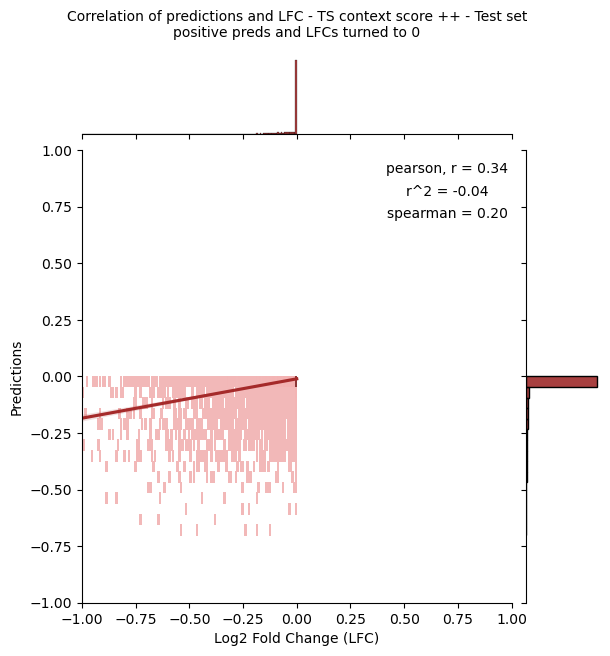

In [ ]:
bartel_on_test_set_fc_positive_preds_zeroed = [x if x<0 else 0 for x in y_test_fc]

plot_correlation(
    bartel_on_test_set_fc_positive_preds_zeroed, 
    data_test['weighted context++ score'],
    'TS context score ++ - Test set\npositive preds and LFCs turned to 0'
)

<Figure size 1500x1500 with 0 Axes>

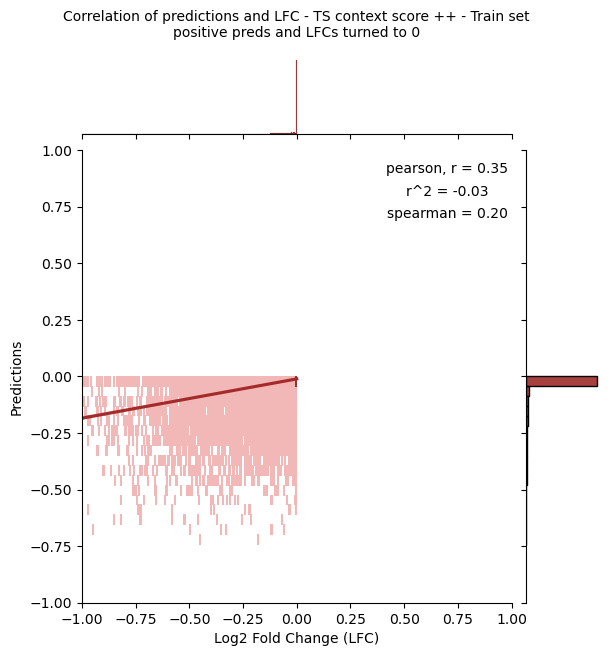

In [ ]:
bartel_on_train_set_fc_positive_preds_zeroed = [x if x<0 else 0 for x in y_train_fc]

plot_correlation(
    bartel_on_train_set_fc_positive_preds_zeroed, 
    data_train['weighted context++ score'],
    'TS context score ++ - Train set\npositive preds and LFCs turned to 0'
)

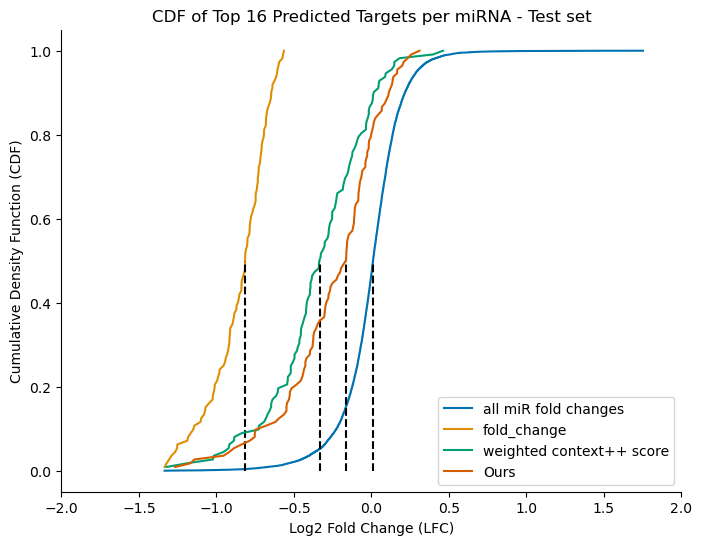

In [ ]:
our_preds_test = pd.DataFrame({
    'miRNA': data_test.miRNA,
    'Ours': y_pred_seeds_signal_tree_test_fc,
    'fold_change': y_test_fc,
})

dataframes = [data_test, data_test, our_preds_test]
labels = ['fold_change', 'weighted context++ score', 'Ours']

plot_multiple_cdfs_with_medians(dataframes, labels, [y_test_fc], ['all miR fold changes'], 'Test set', 16)

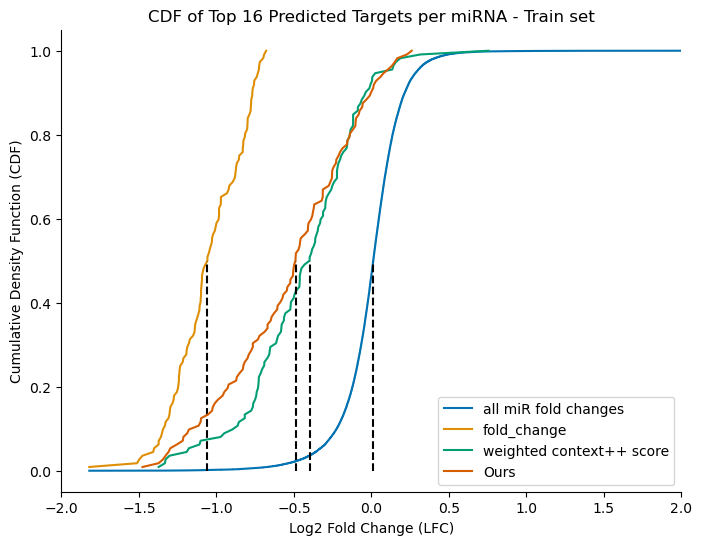

In [ ]:
our_preds_train = pd.DataFrame({
    'miRNA': data_train.miRNA,
    'Ours': y_pred_seeds_signal_tree_train_fc,
    'fold_change': y_train_fc,
})

dataframes = [data_train, data_train, our_preds_train]
labels = ['fold_change', 'weighted context++ score', 'Ours']

plot_multiple_cdfs_with_medians(dataframes, labels, [y_train_fc], ['all miR fold changes'], 'Train set', 16)

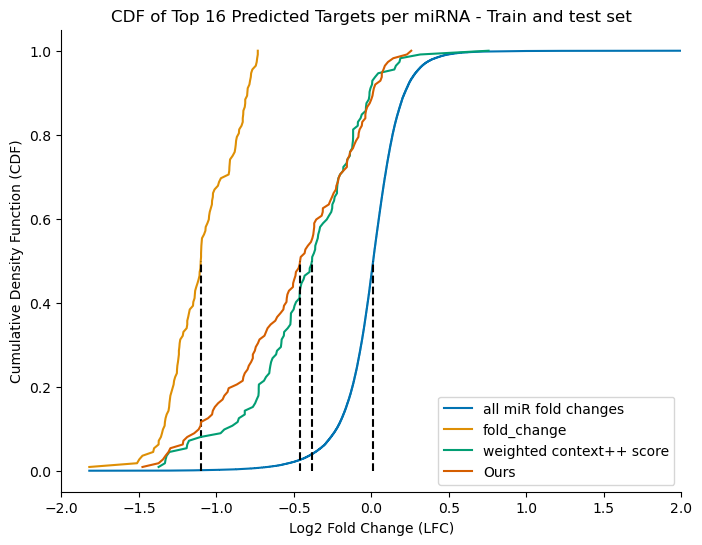

In [ ]:
df_train_test = pd.concat([data_train, data_test], ignore_index=True)

our_preds_train = pd.DataFrame({
    'miRNA': df_train_test.miRNA,
    'Ours': np.concatenate((y_pred_seeds_signal_tree_train_fc,y_pred_seeds_signal_tree_test_fc)),
    'fold_change': df_train_test.fold_change,
})

dataframes = [df_train_test, df_train_test, our_preds_train]
labels = ['fold_change', 'weighted context++ score', 'Ours']

plot_multiple_cdfs_with_medians(
    dataframes, labels, [df_train_test.fold_change.values], ['all miR fold changes'], 'Train and test set', 16
)